In [1]:
import numpy as np
import pylab as plt
from plotting import scatter_contour_color, plotPairwise, plotPairwiseClassifier
from astroML.utils import split_samples
from catalog import Catalog
from astroML.plotting.tools import draw_ellipse
from astroML.classification import GMMBayes
from sklearn.mixture import GMM
from sklearn.svm import SVC
from sklearn.qda import QDA

%matplotlib inline

## Define classifiers that we will use
Each classifier (SVM, QDA, GMM) has a similar interface. To change the classifier in section "Run Classifiers"

In [2]:
#Classifiers
def compute_XD_results(X, Xerr, n_components=10, n_iter=500):
    clf = XDGMM(n_components, n_iter=n_iter)
    clf.fit(X, Xerr)
    return clf

def compute_QDA(X_train, X_test, y_train):
    clf = QDA()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return clf, y_pred
    
def compute_GMMbayes(nGauss, X_train, X_test, y_train):
    clf = GMMBayes(nGauss, min_covar=1E-5, covariance_type='full')
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    return clf, y_pred


def compute_KNN(kvals, X_train, X_test, y_train):
    clf = KNeighborsClassifier(n_neighbors=kvals)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    return clf, type_pred

def compute_SVM(X_train, X_test, y_train, kernel='linear'):
    # perform support vector classification
    clf = SVC(kernel=kernel, gamma=20.0, class_weight='auto',)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    return clf, y_pred

## Read in data into a catalog class and select columns
Data are read from a fits file into the Catalog class

Catalog column names are defined in catalog.tableColumnNames

Columns are selected based on createColumns. The format is a list of lists with and entry ['g', '-', 'r'] creating a new column 'g-r'

In [3]:
createColumns = [['g','-','r'],['r','-','i'],['i','-','W1'],['W1','-','W2'],['W1']]
#createColumns = [['g','-','i'],['i','-','K'],['K','-','W1'],['W1','-','W2'],['W1']]
#['g', 'r', 'i', 'z', 'Y','J', 'K', 'W1', 'W2']
#read and select data columns
catalog = Catalog("y1a1_s82.fits")
catalog.selectColumns(createColumns)
print catalog.tableColumnNames

['ID', 'g', 'r', 'i', 'z', 'Y', 'J', 'K', 'W1', 'W2', 'g_ERR', 'r_ERR', 'i_ERR', 'z_ERR', 'Y_ERR', 'J_ERR', 'K_ERR', 'W1_ERR', 'W2_ERR', 'CLASS', 'FLAG_2WISE', 'redshift']


##Filter data and subselect a random sample
filterSources defines the selection of the sample (currently 13.5<r<19 and flag_2wise !=1)<br>

Data are subsetted using maxPts (for each class type up to maxPts are retained in the traning set)

Data are output as "data", class labels as "objType"

All data are split into a test and training sample (data_train, data_test), (type_train, type_test) with a 75% - 25% split


The frequency of the labels (and number of unique labels are output at the end of the cell)

#Note: we change the class labels to just 1 and 3 (non-QSO and QSO)


In [4]:
# select based on properties and limit to maximum number of points
filterSources = ((catalog.table['r'] > 13.5) & (catalog.table['r'] < 19.) &
                 (catalog.table['FLAG_2WISE'] != 1)) # removes wise sources with two detections in other bands
data = catalog.data.view(np.float64).reshape(catalog.data.shape + (-1,))
data = data[filterSources]
objType = catalog.table['CLASS'][filterSources]
print "Catalog size", len(objType)
print "Number of classes and frequency", np.unique(objType, return_counts=True)

#subselect data if needed (subsample class 1, keep all of class 2 and 3)
maxPts = 50000
_data = np.array([], dtype=np.int64).reshape(0,data.shape[1])
_objType = np.array([], dtype=np.int64).reshape(0,)
for name in np.unique(objType):
    sourceType = np.where(objType == name)[0]
    if (len(sourceType) > maxPts):
        _randomSample = np.random.choice(sourceType, size=maxPts, replace=False)
        _data = np.vstack([_data, data[_randomSample]])
        _objType = np.concatenate([_objType, objType[_randomSample]])
    else:
        _data = np.vstack([_data, data[sourceType]])
        _objType = np.concatenate([_objType, objType[sourceType]])
data = _data
objType = _objType

#NOTE Force class 2 to be class 1
objType[objType == 2] = 3
print "Number of subselected classes and frequency", np.unique(objType, return_counts=True)

# Select test and training sample
(data_train, data_test), (type_train, type_test) = split_samples(data, objType, [0.75, 0.25], random_state=0)

Catalog size 174779
Number of classes and frequency (array([1, 2, 3]), array([163829,  10425,    525]))
Number of subselected classes and frequency (array([1, 3]), array([50000, 10950]))


## Plot the pairwise distribution of points

points are plotted based on their colors (using colormap) as contours and points

/Users/ajc/LSST/Software/lsst/DarwinX86/anaconda/2.1.0/lib/python2.7/site-packages/matplotlib/contour.py:930: UserWarning: linewidths is ignored by contourf
  warnings.warn('linewidths is ignored by contourf')


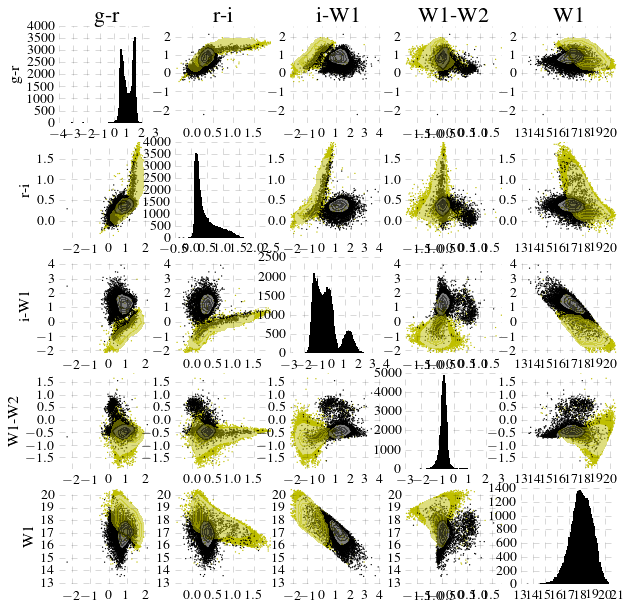

In [5]:
fig = plt.figure(figsize=(10,10))
colormap = np.array(['r','y','b','k'])
for name in np.unique(objType):
    plotPairwise(data[objType==name], fig, plot_args=dict(marker='.', s=7, c=colormap[name], edgecolors='None'),
                     contour_args=dict(colors=colormap[name],), filled_contour=True,
            labels=catalog.dataColumnNames)

##Run Classifiers

select the classifier of interest

output the predicted classifications and frequency of these classifications

In [6]:
clf, type_pred = compute_SVM(data_train, data_test, type_train, kernel='rbf')
#clf, type_pred = compute_QDA(data_train, data_test, type_train)
#clf, type_pred = compute_GMMbayes(5, data_train, data_test, type_train)


ncorr = len(np.where(type_pred == type_test)[0])
print "Completeness:",ncorr/float(len(type_test))
print "Class distribution test input:", np.unique(type_test, return_counts=True)
print "Class distribution test prediction:", np.unique(type_pred, return_counts=True)
#apply to full data set
final_class = clf.predict(data)
print "Class distribution full prediction:", np.unique(final_class, return_counts=True)

Completeness: 0.986809292558
Class distribution test input: (array([1, 3]), array([12442,  2796]))
Class distribution test prediction: (array([1, 3]), array([12419,  2819]))
Class distribution full prediction: (array([1, 3]), array([49873, 11077]))


##Plot the pairwise color distribution of the test sample 

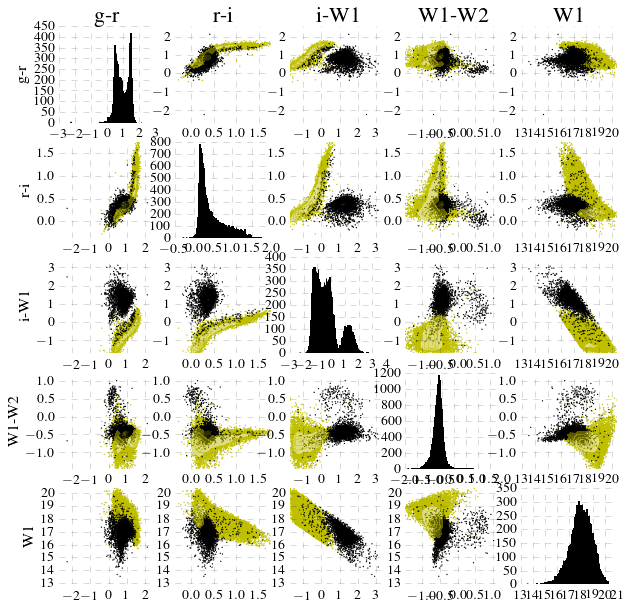

In [7]:
fig = plt.figure(figsize=(10,10))
colormap = np.array(['r','y','b','k'])
for name in np.unique(type_test):
    plotPairwise(data_test[type_test==name], fig, plot_args=dict(marker='.', s=7, c=colormap[type_test[type_test==name]], edgecolors='None'),
                 contour_args=dict(colors=colormap[type_test[type_test==name]],), filled_contour=True, labels=catalog.dataColumnNames)


##Plot the pairwise classified test data

Plot the test data with the predicted classifications

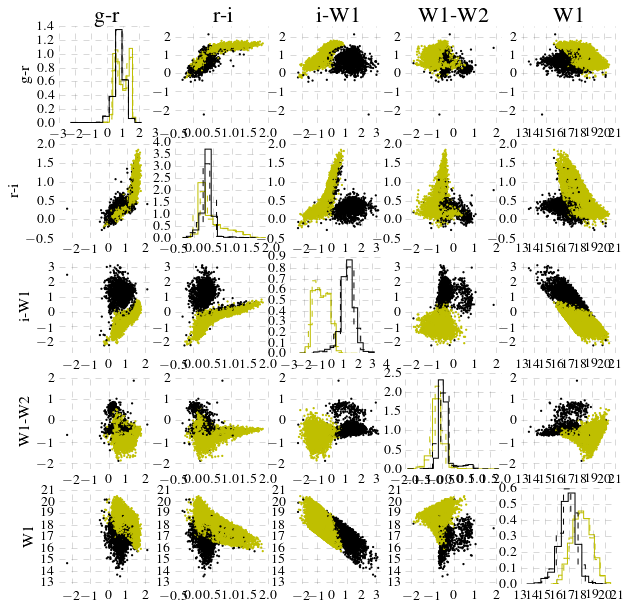

In [8]:
fig = plt.figure(figsize=(10,10))
colormap = np.array(['r','y','b','k'])
plotPairwiseClassifier(data_test, type_test, type_pred, fig, colormap=colormap, labels=catalog.dataColumnNames)

##Plot the classification of the full data set

Plot the full data with the predicted classifications

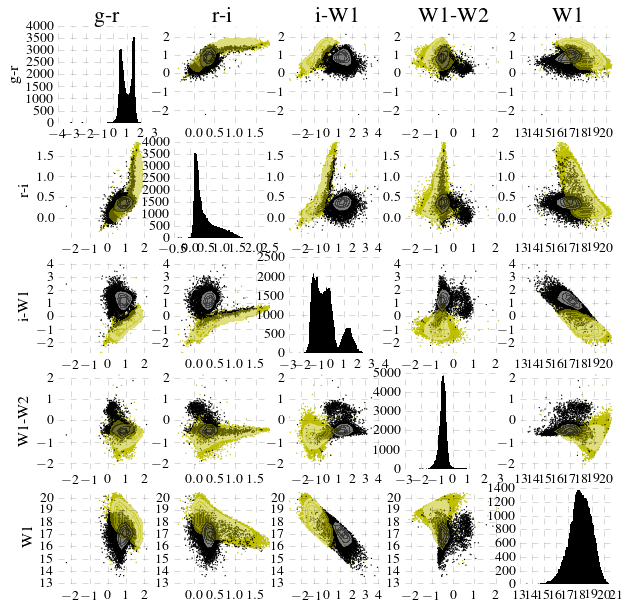

In [9]:
fig = plt.figure(figsize=(10,10))
colormap = np.array(['r','y','b','k'])
for name in np.unique(objType):
    plotPairwise(data[final_class==name], fig, plot_args=dict(marker='.', s=7, c=colormap[name], edgecolors='None'),
                     contour_args=dict(colors=colormap[name],), filled_contour=True, labels=catalog.dataColumnNames)

#IGNORE BELOW HERE


##Plot the density of the probabilities of the ND classifier projected onto 2D
plot classification

give  data_test, type_test, type_pred, clf, 
- generate ND proba for clf and x,y (needs limits on data)

loop through pairwise
 -  marginalize proba
 -  plot density for the marginalized probabilities
 -  plot 50% contour
 -  overlay points (that fail?)
  

(11, 11, 11, 11, 11)
0.0 1.0


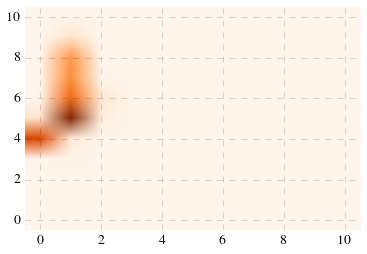

In [211]:
nbins=11
cube = np.meshgrid(*[np.linspace(x.min(), x.max(), nbins) for x in data_train.T])
print cube[4].shape
hist, edges= np.histogramdd(data_train, bins=nbins, range=None, normed=False, weights=None)
image = np.sum(hist, axis=(2,3,4))
image = image/image.max()
print image.min(), image.max()
im = plt.imshow(image, origin='lower', aspect='auto', cmap=plt.cm.Oranges, zorder=1)


In [ ]:
xx,yy,Z = classificationDensity(clf, [ax.get_xlim(),ax.get_ylim()])
im = ax.imshow(Z, origin='lower', aspect='auto', cmap=plt.cm.binary, zorder=1,
                extent=ax.xlim() + ax.ylim())
im.set_clim(0, 1.5)

ax.contour(xx, yy, Z, [0.5], colors='k')



In [87]:
dd=np.meshgrid(*[np.linspace(x.min(), x.max(), 11) for x in data.T])
print len(dd[1].ravel())
print dd[0].shape
PP = np.c_[[xx.ravel() for xx in dd]]
print len(np.c_[dd[0].ravel(),dd[1].ravel()])

161051
(11, 11, 11, 11, 11)
161051


In [89]:
Z = clf.predict_proba(PP.T)
Z = Z[:, 1].reshape(dd[0].shape)
print Z.shape


(11, 11, 11, 11, 11)


In [128]:
nattr=5
a = np.zeros([11 for x in range(nattr)])
for i in range(nattr): #row
    for j in range(nattr): # column
        if (i != j):
            margin = set.difference(set(range(nattr)),set((i,j)))
            np.sum(a, axis=tuple(margin))



In [ ]:
def selectBounds(datax):
    scale = (datax.max() - datax.min())*0.1
    x_min, x_max = datax.min() - scale, datax.max() + scale
    return x_min, x_max

def plotPairwiseClassifier(data_test, type_test, type_pred, classifier, fig, colormap=np.array(['k','y','b','r']),
                           labels=None, limits=None, nbins = 11, plot_probabilites=False,
                           plot_args=None, contour_args=None, filled_contour=False,
                           **kwargs):
    '''Plot a set of pairwise correlations and their classifications'''
    
    # set up plotting parameters and dimensions
    npts, nattr = data_test.shape
    if labels is None:
        labels = ['var%d'%i for i in range(nattr)]

    default_plot_args = dict(marker='.', zorder=1)
    if plot_args is not None:
        default_plot_args.update(plot_args)
    plot_args = default_plot_args


    default_contour_args = dict(zorder=2, alpha=0.5, linewidths=1)
    if contour_args is not None:
        default_contour_args.update(contour_args)
    contour_args = default_contour_args

    # generate array with probabilites for the classification
    if plot_probabilites:
        cube = np.meshgrid(*[np.linspace(x.min(), x.max(), nbins) for x in data_test.T])
        points = np.c_[[xx.ravel() for xx in cube]]
        Z = clf.predict_proba(points.T)
        Z = Z[:, 1].reshape(cube[0].shape)
    
    for i in range(nattr): #row
        for j in range(nattr): # column
            nSub = i * nattr + j + 1
            ax = fig.add_subplot(nattr, nattr, nSub)
            if i == j:
                margin = set.difference(set(range(nattr)),set([i]))
                hist = np.sum(Z, axis=tuple(margin))
                hist /= hist.max()

                ax.bar(range(0,nbins), hist)
                if (limits != None):
                    ax.set_xlim(limits[i])
            else:
                if (limits != None):
                    ax.set_xlim(limits[j])
                    ax.set_ylim(limits[i])
                else:
                    amin, amax = selectBounds(data_test[:,j])
                    ax.set_xlim((amin,amax))
                    amin, amax = selectBounds(data_test[:,i])
                    ax.set_ylim((amin,amax))
                
                margin = set.difference(set(range(nattr)),set((i,j)))
                image = np.sum(Z, axis=tuple(margin))
                image = image/image.max()
                print image.min(), image.max()
#                im = ax.imshow(image, origin='lower', aspect='auto', cmap=plt.cm.Oranges, zorder=1,
#                               extent=ax.get_xlim() + ax.get_ylim())
#                xx,yy = np.meshgrid(np.linspace(data_test[j].min(), data_test[j].max(), nbins),
#                                    np.linspace(data_test[i].min(), data_test[i].max(), nbins))
#                ax.contour(xx, yy, image, [0.5], colors='red')
                ax.scatter(data_test[:,j],data_test[:,i], marker='.', edgecolors='None',
                           c=colormap[type_pred],zorder=5)
                print data_test.shape
            if (i==0):
                ax.set_title(labels[j])
            if (j==0):
                ax.set_ylabel(labels[i])


